# Modelando os tópicos da RBEF ao longo do tempo usando Latent Dirichlet Allocation 

## Imports


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from multiprocessing import Pool

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from gensim.models import CoherenceModel

from utils.pre_processing import tokenizer, html_to_text
from utils.model import add_bigram, create_dictionary, create_corpus, process_combination
from utils.model import ModelLDA, calc_coherence
from utils.plots import plot_frequent_words

## Leitura do banco de dados

In [3]:
df = pd.read_feather('scielo_dataset.feather')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664 entries, 0 to 1663
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   titulo      1664 non-null   object
 1   ano         1664 non-null   uint16
 2   seção       1664 non-null   object
 3   nova_seção  1664 non-null   object
 4   doi_id      1644 non-null   object
 5   texto_html  1664 non-null   object
dtypes: object(5), uint16(1)
memory usage: 68.4+ KB


In [5]:
df['nova_seção'].value_counts(normalize=True) * 100

nova_seção
artigos gerais                         48.497596
pesquisa em ensino de física           14.182692
produtos e materiais didáticos         12.139423
história da física e ciências afins     9.314904
outros                                  8.954327
seções especiais                        5.949519
SEM CATEGORIA                           0.961538
Name: proportion, dtype: float64

## Tokenizaçao e Lemmetização

In [ ]:
with Pool() as pool:
    # limpa o html dos textos.
    textos = list(tqdm(pool.imap(html_to_text, df['texto_html']), total=len(df)))
    
with Pool() as pool:
    # tokeniza e lemmetiza os textos.
    documentos = list(tqdm(pool.imap(tokenizer, textos), total=len(textos)))

  0%|          | 0/1664 [00:00<?, ?it/s]

  0%|          | 0/1664 [00:00<?, ?it/s]

# Escolhendo o melhor filtro

In [ ]:
bigram = [5, 10, 15, 20]
acima = np.arange(0.1, 1, 0.1)
abaixo = np.arange(10, 50, 5)

combinations = [((bi, a, b), documentos) for bi in bigram for a in acima for b in abaixo]

with Pool(4) as pool:
    results = list(tqdm(pool.imap(process_combination, combinations), total=len(combinations)))

In [ ]:
result = {key: value for key, value in results}

## Bigram e criação do dicionário

In [7]:
add_bigram(documentos, min_count=15)

In [8]:
dicionario_sem_filtro = create_dictionary(documentos, filtrar=False)
dicionario = create_dictionary(documentos, n_abaixo=30, n_acima=0.5)

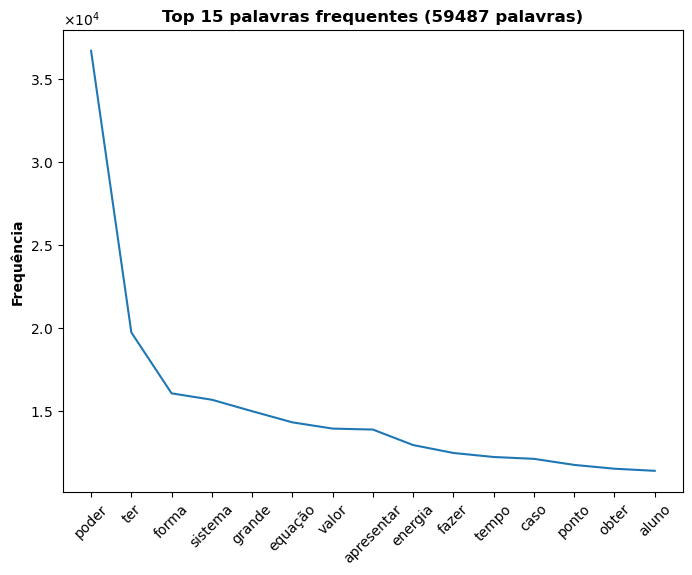

In [9]:
plot_frequent_words(dicionario_sem_filtro, filename='dicionario_completo.png')

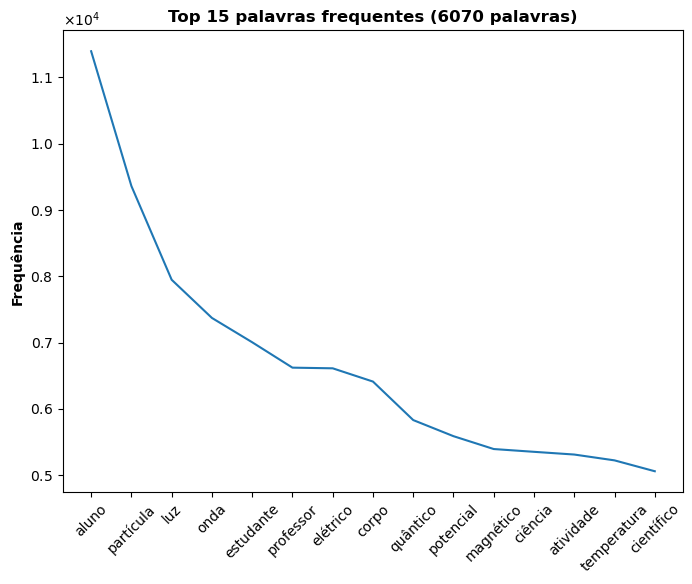

In [10]:
plot_frequent_words(dicionario, filename='dicionario_filtro.png')

In [11]:
corpus = create_corpus(dicionario, documentos)

In [12]:
lda = ModelLDA(corpus, dicionario, chunksize=2000, iterations=400, passes=50)

In [13]:
model = lda.run(12)

In [14]:
model.print_topics()

[(0,
  '0.048*"luz" + 0.025*"onda" + 0.018*"imagem" + 0.014*"raio" + 0.012*"cor" + 0.011*"lente" + 0.010*"feixe" + 0.010*"refração" + 0.009*"espelho" + 0.009*"objeto"'),
 (1,
  '0.017*"partícula" + 0.015*"quântico" + 0.015*"potencial" + 0.009*"vetor" + 0.009*"operador" + 0.007*"onda" + 0.006*"interação" + 0.006*"simetria" + 0.006*"matriz" + 0.005*"clássico"'),
 (2,
  '0.025*"temperatura" + 0.019*"radiação" + 0.010*"onda" + 0.010*"átomo" + 0.010*"calor" + 0.009*"partícula" + 0.008*"frequência" + 0.008*"solar" + 0.007*"superfície" + 0.007*"corda"'),
 (3,
  '0.019*"aluno" + 0.016*"professor" + 0.012*"estudante" + 0.010*"atividade" + 0.009*"aula" + 0.008*"científico" + 0.008*"ciência" + 0.007*"pesquisa" + 0.007*"conteúdo" + 0.007*"curso"'),
 (4,
  '0.037*"aluno" + 0.017*"estudante" + 0.010*"aula" + 0.009*"pêndulo" + 0.009*"curso" + 0.009*"disciplina" + 0.008*"item" + 0.008*"atividade" + 0.008*"gráfico" + 0.008*"software"'),
 (5,
  '0.009*"ar" + 0.009*"corpo" + 0.007*"atrito" + 0.007*"acele

In [15]:
topicos = model.get_document_topics(corpus)
df['topicos'] = [max(topic, key=lambda x: x[1])[0] for topic in topicos]

In [16]:
pd.crosstab(df['nova_seção'], df['topicos'])

topicos,0,1,2,3,4,5,6,7,8,9,10,11
nova_seção,,,,,,,,,,,,
SEM CATEGORIA,0,1,2,1,1,0,1,3,1,0,3,3
artigos gerais,51,190,82,24,9,115,58,56,99,48,12,63
história da física e ciências afins,12,6,8,7,0,5,0,14,2,8,79,14
outros,2,15,6,39,5,10,8,13,2,4,31,14
pesquisa em ensino de física,9,2,11,122,37,18,21,3,1,6,4,2
produtos e materiais didáticos,25,4,18,41,9,33,47,6,2,11,3,3
seções especiais,3,10,8,10,10,4,1,1,10,2,27,13


In [45]:
for n in df.topicos.value_counts():
    print(f'{n}')

244
228
185
159
136
135
117
112
102
96
79
71


In [33]:
df.topicos.value_counts().keys()

Index([3, 1, 5, 10, 6, 2, 8, 11, 0, 7, 9, 4], dtype='int64', name='topicos')

In [32]:
for i in df.topicos.value_counts().keys():
    topics = model.show_topic(i)
    palavras = ', '.join([elem[0] for elem in topics])
    print(palavras)

aluno, professor, estudante, atividade, aula, científico, ciência, pesquisa, conteúdo, curso
partícula, quântico, potencial, vetor, operador, onda, interação, simetria, matriz, clássico
ar, corpo, atrito, aceleração, esfera, coeficiente, altura, pressão, eixo, superfície
ciência, corpo, científico, livro, século, natureza, publicar, matéria, época, história
circuito, corrente, tensão, sinal, frequência, elétrico, placa, sensor, capacitor, porta
temperatura, radiação, onda, átomo, calor, partícula, frequência, solar, superfície, corda
distribuição, rede, parâmetro, fase, comportamento, simulação, probabilidade, escala, numérico, estrutura
partícula, corpo, quântico, mecânico, referencial, clássico, equilíbrio, relatividade, coordenada, entropia
luz, onda, imagem, raio, cor, lente, feixe, refração, espelho, objeto
magnético, elétrico, carga, corrente, campo_magnético, eletromagnético, campo_elétrico, condutor, fio, potencial
estrela, sol, planeta, universo, órbita, solar, lua, observação

In [38]:
names = ['Ensino',
'Mecânica Quântica',
'Mecânica Clássica',
'História da Ciência',
'Circuito Elétrico',
'Termodinâmica',
'Física dos Materiais',
'Física Moderna',
'Ótica',
'Eletromagnetismo',
'Astronomia',
'Metodologia']

dici = { names[i]:k for i, k in enumerate(df.topicos.value_counts().keys())}

In [40]:
for k,v in enumerate(dici):
    print(k, v)

0 Ensino
1 Mecânica Quântica
2 Mecânica Clássica
3 História da Ciência
4 Circuito Elétrico
5 Termodinâmica
6 Física dos Materiais
7 Física Moderna
8 Ótica
9 Eletromagnetismo
10 Astronomia
11 Metodologia


In [19]:
coerencia = calc_coherence(model, documentos, dicionario, corpus, method='c_v')
coerencia.get_coherence()

0.6137001539282075

In [20]:
for i, co in enumerate(coerencia.get_coherence_per_topic()):
    print(str(co).replace('.',','))

0,734747704089417
0,5238938160106619
0,5820039213581147
0,7720594391534965
0,5975863118018149
0,570877247093713
0,7081657310670313
0,5411921575538372
0,4481989442692931
0,7526615249177289
0,6288631156944553
0,5041519341289258


/tmp/ipykernel_77481/1078811258.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0,35,5), fontsize=14)


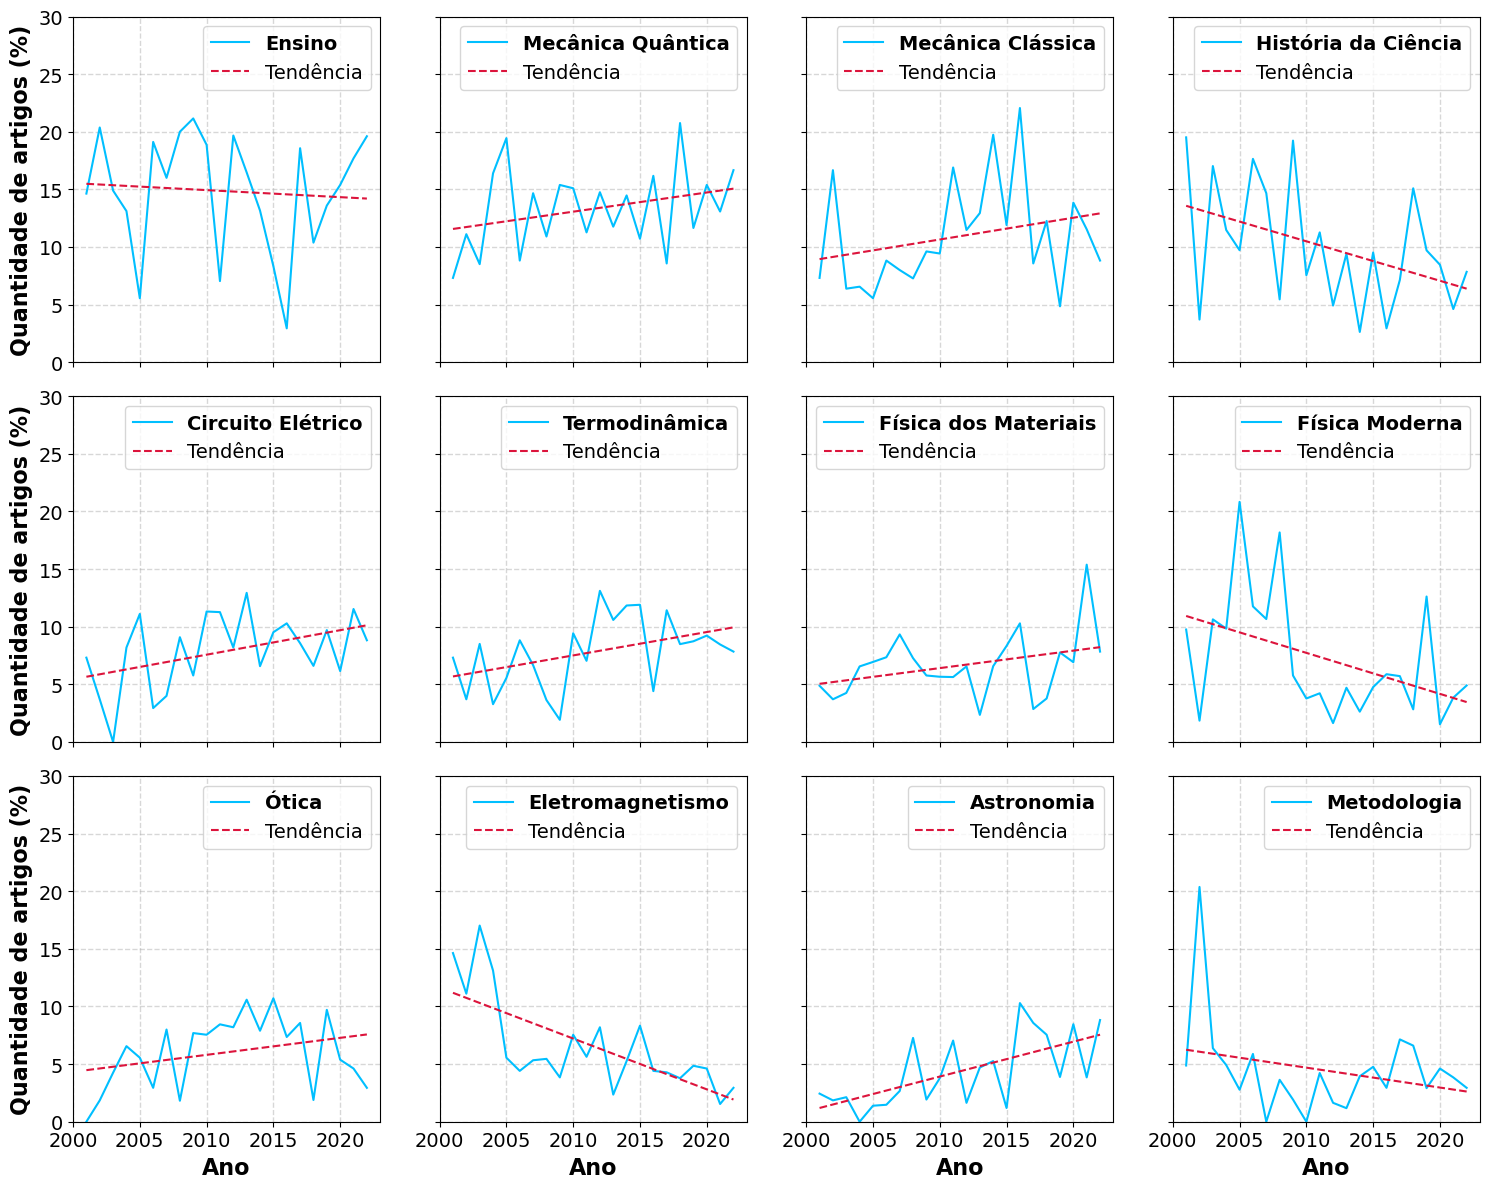

In [47]:
df_agrupado = df.pivot_table(index='ano', columns='topicos', aggfunc='size', fill_value=0)

# Calcular a soma total de frequências por ano
df_agrupado['frequencia_total'] = df_agrupado.sum(axis=1)

# Calcular a porcentagem do tópico em relação ao total no ano
df_porcentagem = df_agrupado.divide(df_agrupado['frequencia_total'], axis=0) * 100

# Se desejar, reorganize as colunas
df_porcentagem = df_porcentagem[['frequencia_total'] + list(df_agrupado.columns.drop('frequencia_total'))]

# Criar subplot 3x4
fig, axs = plt.subplots(3, 4, figsize=(15, 12))

# Iterar sobre os tópicos e plotar cada um em um subplot separado
for i, topico in enumerate(dici):
    id_ = dici[topico]
    dados_topico = df_porcentagem[id_]
    x, y = dados_topico.keys(), dados_topico.values
    fit = np.polyfit(x, y, 1)
    
    ax = axs[i // 4, i % 4]  # Determinar a posição do subplot
    ax.plot(x, y, label=f'{topico}', c='deepskyblue')
    ax.plot(x, fit[0]*x + fit[1], ls='--', label='Tendência', c='crimson')
    # ax.set_title(f'Tópico {topico+1}', weight='bold', size=15)
    ax.set_ylim([0, 30])
    ax.set_xlim([2000, 2023])
    ax.tick_params(axis='x', labelsize=14) 
    
    ax.grid(alpha=0.5, ls='--', lw=1)
    legenda = ax.legend(fontsize=14)
    legenda.get_texts()[0].set_fontweight('bold')
    
    if i >= 8:
        ax.set_xlabel('Ano', weight='bold', size=16)
    else:
        ax.xaxis.set_tick_params(labelbottom=False)
        
    if i % 4 == 0:
        ax.set_ylabel('Quantidade de artigos (%)', weight='bold', size=16)
        ax.set_yticklabels(range(0,35,5), fontsize=14)
    else:
        ax.yaxis.set_tick_params(labelleft=False)
        
    
    
# Ajustar espaçamento entre subplots
plt.tight_layout()
# Exibir o gráfico
plt.show()
fig.savefig('plots/tópicosporano.png', dpi=300, bbox_inches='tight')